In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ccaModels import CCA_MarkovChain_CUBIC_OG, CCA_MarkovChain_Hybla_discrete, CCA_MarkovChain_Hybla, CCA_MarkovChain_CUBIC_new

#plt.rcParams['text.usetex'] = True
plt.rcParams.update(plt.rcParamsDefault)

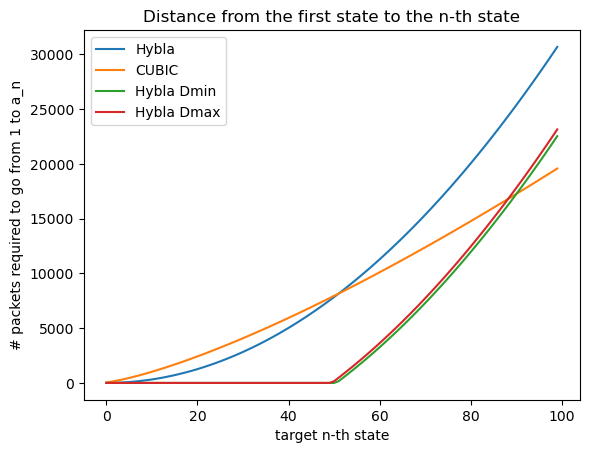

1.0
157.0


In [20]:
hyb = CCA_MarkovChain_Hybla_discrete(packet_err=0.0006,beta=0.5,N=100,C =1000, RTT_est=0.2, RTT_real = 0.5, RTT0=0.1)
cub = CCA_MarkovChain_CUBIC_new(packet_err = 0.0006, beta=0.5,N=100,C =1000, RTT_est=0., RTT_real = 0.5,alpha=0.001)

a = 1
d = np.zeros(100)
dc = np.zeros(100)
for i,ai in enumerate(hyb.a):
    d[i] = hyb.D(1,ai)
for i,ai in enumerate(cub.a):
    dc[i] = cub.D(1,ai)
plt.title("Distance from the first state to the n-th state")
plt.ylabel("# packets required to go from 1 to a_n")
plt.xlabel("target n-th state")
plt.plot(d,label="Hybla") 
plt.plot(dc,label="CUBIC")
plt.plot(hyb.Dmin[50,:], label = "Hybla Dmin")
plt.plot(hyb.Dmax[50,:], label = "Hybla Dmax")
plt.legend()             
plt.show()
print(hyb.Dmin[50,50])
print(hyb.Dmax[50,50])

Average throughput is 0.5108174855618983


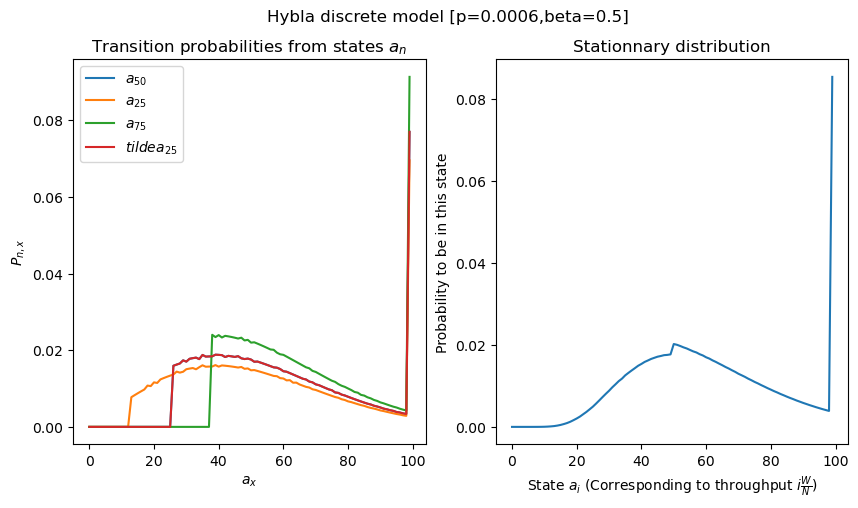

In [23]:
p = 0.0006
b = 0.5
wired = CCA_MarkovChain_Hybla_discrete(packet_err=p,beta=b,N=100,C =1000, RTT_est=0.2, RTT_real = 0.21, RTT0=0.1)
wired.avg_throughput()
print(f"Average throughput is {wired.ssThroughput}")

fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].plot(np.arange(wired.N),wired.P[50,:],label = "$a_{50}$")
axs[0].plot(np.arange(wired.N),wired.P[25,:],label = "$a_{25}$")
axs[0].plot(np.arange(wired.N),wired.P[75,:],label = "$a_{75}$")
axs[0].plot(np.arange(wired.N),wired.Ptilde[25,:],label = "$tilde a_{25}$")
axs[0].set_title(r"Transition probabilities from states $a_n$")
axs[0].set_ylabel(r"$P_{n,x}$")
axs[0].set_xlabel(r"$a_x$")
axs[0].legend()
axs[1].plot(np.arange(wired.N),wired.pi)
axs[1].set_title(r"Stationnary distribution")
axs[1].set_xlabel(r"State $a_i$ (Corresponding to throughput $i\frac{W}{N}$)")
axs[1].set_ylabel(r'Probability to be in this state')
fig.suptitle(f"Hybla discrete model [p={p},beta={b}]")
plt.show()

Now I wish to print the stationnary distribution for different p.
We see that there's something not quite right in the way that large p (0.1) should yield stationnary distribution with a lower center of mass. But is seems to go down then up for some reason.
* Try more extreme values of p. --> For p<0.0001 and p>1(I mean obviously p has to be smaller than 1) it looks like the eigenvalue computation doesn't converge.
* See how p influences the probabilities. --> It looks like the transition probabilities are all around. For increasing p, the weight should go more towards lower values.
* Looks like it might come from Dmin or Dmax, check both. 

### OK, I think I cracked the problem:
WHY WITH 0.5 P(i,beta*i)=0? it should be equal to 1! --> make a plot looking at P(i,beta i) as a function of p.
It's a numerical error for large p (then (1-p)^Dmin and (1-p)^Dmax make the probabilities skyrocket).
But more than that, when we recover P from Ptilde we might miss the good one.

* Have a look again at if this is well implemented.
* Would make more sense to test the CUBIC implementation (although you're impatent for the Hybla one) So that we can compare with the raw CUBIC (we're at least pretty much sure this one works.)

0.0 7.450580596923828e-09
0.0 0.057972772657612096
0.0 0.3237252125371928
0.0 0.2395293496859423
0.0 0.052113930348505755
0.0 0.0054703854621200865


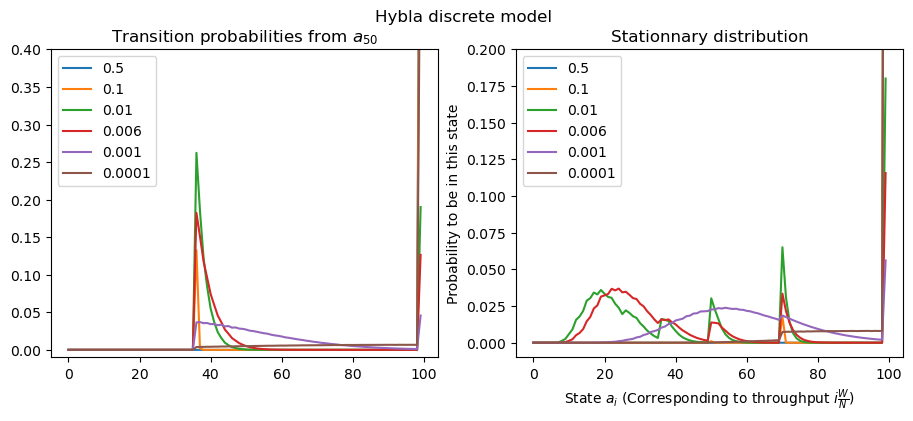

In [32]:
wired = CCA_MarkovChain_Hybla_discrete(packet_err=0.1,beta=0.7,N=100,C = 1000,RTT_est=0.2, RTT_real = 0.21, RTT0=0.1)
ps = [0.5,0.1,0.01,0.006,0.001,0.0001]
fig, axs = plt.subplots(1, 2, figsize=(11,4))
for i in ps:
    wired.packet_err = i
    wired.compute_stationnary_distribution()
    axs[0].plot(np.arange(wired.N),wired.P[50,:],label=f"{i}")
    axs[1].plot(np.arange(wired.N),wired.pi,label=f"{i}")
    print(wired.P[50,25], wired.Ptilde[50,51])

axs[1].set_title(r"Stationnary distribution")
axs[0].set_title(r"Transition probabilities from $a_{50}$")
axs[1].set_ylim(-0.01,0.2)
axs[0].set_ylim(-0.01,0.4)
axs[1].set_xlabel(r"State $a_i$ (Corresponding to throughput $i\frac{W}{N}$)")
axs[1].set_ylabel(r'Probability to be in this state')
axs[1].legend()
axs[0].legend()
fig.suptitle(f"Hybla discrete model")
plt.show()

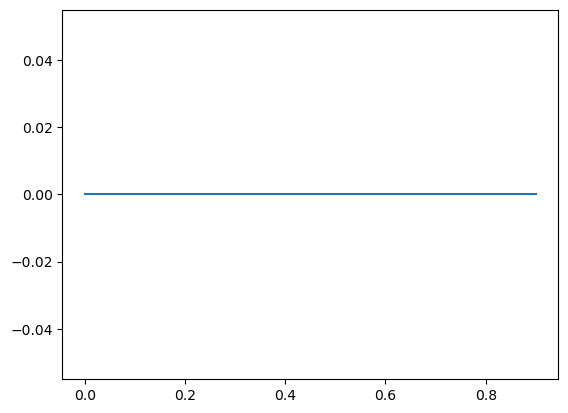

In [37]:
hyb = CCA_MarkovChain_Hybla_discrete(packet_err=0.0006,beta=0.7,N=100,C =1000, RTT_est=0.2, RTT_real = 0.21, RTT0=0.1)
x = np.arange(20)
ps = np.linspace(0.00001,0.9,20)
for i,p in enumerate(ps):
    hyb.packet_err = p
    wired.compute_stationnary_distribution()
    x[i] = wired.P[50,26]
plt.plot(ps,x)
    

In [19]:
print(hyb.a[1],hyb.a[4])
print(hyb.a[2]-0.5*hyb.a[5])
print(hyb.T(hyb.a[1],hyb.a[5]))
#self.RTT0**2*(y-self.beta*x)/self.RTT_real
(5-0.5)*hyb.W/hyb.N

15.75 47.25
-2.625
0.05250000000000008


47.25

3.621964664966512
6.020404329078785


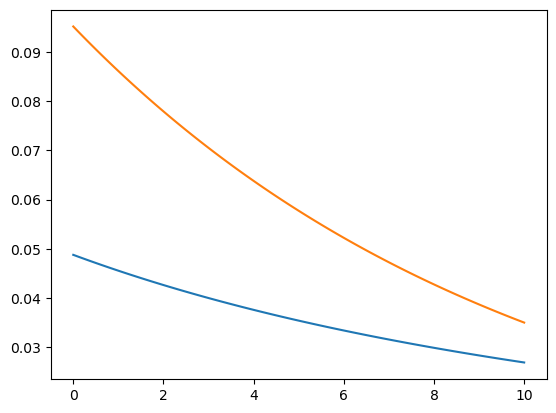

In [23]:
t = np.linspace(0,10,100)
w0 = 100
rtt = 0.5
l = 1/10
e = 0.1
w = w0+t/rtt # cwnd in MSS
b = w/rtt # MSS/s

p = np.exp(-t/(e*b))-np.exp(-(t+1)/(e*b))
pold = np.exp(-l*t)-np.exp(-l*(t+1))

plt.plot(t,p)
plt.plot(t,pold)
print(np.sum(np.exp(-t/(e*b))-np.exp(-(t+1)/(e*b))))
print(np.sum(np.exp(-l*t)-np.exp(-l*(t+1))))

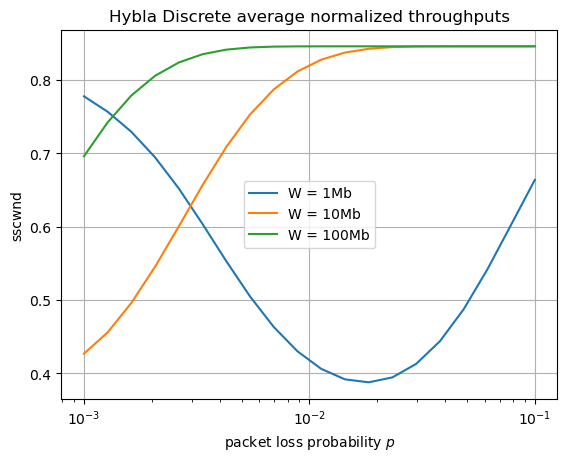

In [12]:
err_rates = np.logspace(-3,-1,20)
throughputs = np.zeros([3,len(err_rates)])
for k,C in enumerate([100,500,1000]):
    for i, l in enumerate(err_rates):
        wireless = CCA_MarkovChain_Hybla_discrete(packet_err=l,beta=0.7,N=100,C = C,RTT_real=0.5, RTT0=0.025)
        throughputs[k,i] = wireless.avg_throughput()

plt.plot(err_rates,throughputs[0,:], label = "W = 1Mb")
plt.plot(err_rates,throughputs[1,:], label = "W = 10Mb")
plt.plot(err_rates,throughputs[2,:], label = "W = 100Mb")
plt.semilogx()
plt.legend()
plt.grid()
plt.title(r"Hybla Discrete average normalized throughputs")
plt.xlabel(r"packet loss probability $p$")
plt.ylabel(r'sscwnd')
plt.show()

In [8]:
def wc(t):
    return (t-np.cbrt(100*0.3))**3+100

def w_next(w,rtt,t):
    return w+(wc(t+rtt)-w)/w

In [15]:
rtt = 0.1
c = 70
for i in range(70):
    c = w_next(c,rtt,rtt+i*rtt)
    if i%10==0:
        print(c)
print(c)
print(wc(rtt))

70.07754383438456
72.24928012790619
75.43804769716698
78.43866153992114
81.05014108817197
83.7968869647492
87.73479597878843
93.42292949741868
72.80425117863827


In [27]:
p=0.01
(1-p)**0-(1-p)**150

0.7785482127611391